# Text Mining by LDA

In [2]:
import pandas as pd 
import numpy as np
from tqdm import tqdm 
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import collections
import wordcloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import spacy
import gensim.corpora as corpora
from gensim.models import LdaMulticore, CoherenceModel, Phrases, LdaModel
import time
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure,show,output_notebook
import pyLDAvis
import pyLDAvis.gensim_models
from sentence_transformers import SentenceTransformer
import warnings
import pprint
# import tensorflow as tf

%matplotlib inline

In [3]:
from keybert import KeyBERT

In [4]:

queries=['What is known about transmission, incubation, and environmental stability?',
         'What do we know about COVID-19 risk factors?',
         'What do we know about virus genetics, origin, and evolution?',
         ' What do we know about vaccines and therapeutics?',
         'What do we know about non-pharmaceutical interventions?',
         ' What has been published about medical care?',
         'What do we know about diagnostics and surveillance?',
         ' What has been published about information sharing and inter-sectoral collaboration?',
         'What has been published about ethical and social science considerations?']
kw_model = KeyBERT()
question_key_words=[]


In [5]:
i=0
keys=[]
for question in queries:
    tmp=kw_model.extract_keywords(question, keyphrase_ngram_range=(1, 1), stop_words='english',use_mmr=True, diversity=0.2)
    # print((tmp))
    key=[]
    for t in tmp:
        key.append(t[0])
        # print(key)
    keys.append(key)
print(keys)

    

[['incubation', 'stability', 'environmental', 'transmission', 'known'], ['covid', 'risk', 'factors', '19', 'know'], ['evolution', 'virus', 'genetics', 'origin', 'know'], ['vaccines', 'therapeutics', 'know'], ['interventions', 'pharmaceutical', 'non', 'know'], ['medical', 'published', 'care'], ['diagnostics', 'surveillance', 'know'], ['collaboration', 'information', 'sharing', 'sectoral', 'inter'], ['ethical', 'published', 'social', 'considerations', 'science']]


# 数据预处理

In [6]:
data = pd.read_csv('metadata.csv',
                  usecols=['cord_uid','source_x','title','license','publish_time',
                           'abstract','authors','journal','url'])
data.head()

,cord_uid,source_x,title,license,abstract,publish_time,authors,journal,url
0,ug7v899j,PMC,Clinical features of culture-proven Mycoplasma...,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...
1,02tnwd4m,PMC,Nitric oxide: a pro-inflammatory mediator in l...,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...
2,ejv2xln0,PMC,Surfactant protein-D and pulmonary host defense,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...
3,2b73a28n,PMC,Role of endothelin-1 in lung disease,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...
4,9785vg6d,PMC,Gene expression in epithelial cells in respons...,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...


In [7]:
def search_focus(df):
    '''仅保留包含关键词语的论文'''

    dfa = df[df['abstract'].str.contains('covid')]
    dfb = df[df['abstract'].str.contains('-cov-2')]
    dfc = df[df['abstract'].str.contains('cov2')]
    dfd = df[df['abstract'].str.contains('ncov')]
    frames=[dfa,dfb,dfc,dfd]
    df = pd.concat(frames)
    df=df.drop_duplicates(subset='title', keep="first")
    return df

def year_focus(df):
    '''
    仅保留2020年及以后的论文
    '''
    dfa = df[df['publish_time']=='2020']
    dfb = df[df['publish_time']=='2021']
    dfc = df[df['publish_time']=='2022']
    frames=[dfa,dfb,dfc]
    df = pd.concat(frames)
    df=df.drop_duplicates(subset='title', keep="first")
    return df 

In [8]:
# data = data[data.publish_time=='2022'or'2021'or'2020']
# 填充缺省值
data=data.fillna('N/A')
data=year_focus(data)
print(f'There are {len(data)} articles published in recent 3 years')

There are 388180 articles published in recent 3 years


In [9]:
len1 = len(data)
data.dropna(axis=0,how='any',subset=['abstract'],inplace=True)
print(f'Dropped {len1-len(data)} articles with missing abstract')

Dropped 0 articles with missing abstract


In [10]:
len1 = len(data)
data.drop_duplicates(subset=['abstract'],keep='first',inplace=True)
print(f'Dropped {len1-len(data)} articles with duplicate abstract')

Dropped 98756 articles with duplicate abstract


In [11]:
data['abstract'] = data['abstract'].apply(lambda x: x.strip().lower())
stopwords = set(stopwords.words('english'))
data['abstract_tokens'] = data['abstract'].apply(lambda x: word_tokenize(x))

## Remove non-English words
data['abstract_tokens'] = data['abstract_tokens'].apply(lambda x: [w for w in x if w.isalpha()])

## Remove Stopwords
data['abstract_tokens'] = data['abstract_tokens'].apply(lambda x: [w for w in x if w not in stopwords])

## Remove words with single characters
data['abstract_tokens'] = data['abstract_tokens'].apply(lambda x: [w for w in x if len(w)>1])
#data['abstract_cleaned'] = data['abstract_tokens'].apply(lambda x: ' '.join(x))
data.head()

,cord_uid,source_x,title,license,abstract,publish_time,authors,journal,url,abstract_tokens
12138,faj682bp,PMC,Coagulation profile in severe COVID-19 patient...,cc-by,n/a,2020,"Savioli, Felicio; Rocha, Leonardo Lima",Rev Bras Ter Intensiva,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,[]
69913,j5rgap05,PMC,A Compendium of Rationales and Techniques for ...,cc-by-nc-sa,a review of active learning in college science...,2020,"Gary Reiness, C.",CBE Life Sci Educ,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8...,"[review, active, learning, college, science, c..."
75195,oj0kqr33,Medline,"Predictive Models on the Rise, But Do They Wor...",unk,predictive models are designed to remove some ...,2020,"Mertz, Leslie",IEEE pulse,https://doi.org/10.1109/mpuls.2020.3036151; ht...,"[predictive, models, designed, remove, subject..."
75277,9efc55lc,Medline,Applying Osteosarcoma Immunology to Understand...,unk,"osteosarcoma, the most common malignant bone t...",2020,"Pratt, Hillary G; Justin, E Markel; Lindsey, B...",Advances in experimental medicine and biology,https://doi.org/10.1007/978-3-030-43085-6_6; h...,"[osteosarcoma, common, malignant, bone, tumor,..."
75336,dxq9g5nt,Medline,"[""We felt we had an important role""].",unk,"at the libourne hospital center, the institute...",2020,"Pallaro, Audrey; Castello, Christine","Soins. Pediatrie, puericulture",https://doi.org/10.1016/j.spp.2020.10.006; htt...,"[libourne, hospital, center, institute, nursin..."


In [12]:
data.reset_index(drop=True,inplace=True)

In [13]:
inverted_idx = {}
for idx,sentence in enumerate(list(data['abstract_tokens'])):
    for token in set(sentence):
        if token not in inverted_idx:
            inverted_idx[token] = [idx]
        else:
            inverted_idx[token].append(idx)

print(f'There are {len(inverted_idx)} unique words in inverted index')

There are 330634 unique words in inverted index


# 数据清洗

In [14]:
%%time
keywords_risk=keys[1]
risk_idx = []
for word in keywords_risk:
    try:
        risk_idx += inverted_idx[word]
    except:
        pass
risk_idx = list(set(risk_idx))
print(f'Found {len(risk_idx)} articles related to risk')

Found 80048 articles related to risk
CPU times: total: 0 ns
Wall time: 9 ms


In [15]:
risk_article = data.iloc[risk_idx,:]
risk_article.head()

,cord_uid,source_x,title,license,abstract,publish_time,authors,journal,url,abstract_tokens
262147,liw4ko9g,Medline; WHO,Unique Predictors of Intended Uptake of a COVI...,unk,purpose: to explore public confidence in a cov...,2021,"Lennon, Robert P; Small, Meg L; Smith, Rachel ...",Am J Health Promot,https://doi.org/10.1177/08901171211026132; htt...,"[purpose, explore, public, confidence, vaccine..."
262151,uj0j94iq,Medline; WHO,Risk Factors Associated With Health Care Utili...,unk,introduction: the severity of wheezing episode...,2021,"Muñoz, César; Guevara, Lissette; Escamilla, Ma...",Front Allergy,https://www.ncbi.nlm.nih.gov/pubmed/35387009/;...,"[introduction, severity, wheezing, episodes, r..."
262152,5j6fmq3p,Medline; WHO,Higher rates of COVID-19 but less severe infec...,unk,objective: dupilumab (dupixent®) is a monoclon...,2021,"Mahroum, N; Damiani, G; Watad, A; Amital, H; B...",Eur Rev Med Pharmacol Sci,https://doi.org/10.26355/eurrev_202109_26808; ...,"[objective, dupilumab, monoclonal, antibody, i..."
11,n1ckrb1y,Medline,Family-related non-abuse adverse life experien...,cc-by,background although previous reviews suggest a...,2020,"Grogan, Katie; MacGarry, Diarmuid; Bramham, Je...",Journal of eating disorders,https://doi.org/10.1186/s40337-020-00311-6; ht...,"[background, although, previous, reviews, sugg..."
262157,mobr931n,Medline; WHO,"COVID-19 pandemic and the psyche, bruxism, tem...",unk,objective: to investigate the effect of the co...,2021,"Colonna, Anna; Guarda-Nardini, Luca; Ferrari, ...",Cranio,https://doi.org/10.1080/08869634.2021.1989768;...,"[objective, investigate, effect, coronavirus, ..."


In [16]:
def lemmatization(texts, allowed_postags=['NOUN','ADJ','VERB','ADV']):
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        ##'-PRON-' is used as the lemma for all pronouns such as their, you, me, and I
        texts_out.append([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' 
                          for token in doc if token.pos_ in allowed_postags])
    return texts_out   

In [17]:
risk_article=data
risk_article['Lemma_Tokens'] = lemmatization(list(risk_article['abstract_tokens']))
bigram = Phrases(list(risk_article['Lemma_Tokens']), min_count=3)
risk_article['Phrase_Lemma_Tokens'] = risk_article['Lemma_Tokens'].apply(lambda x: bigram[x])


# LDA

100%|██████████| 8/8 [1:45:04<00:00, 788.08s/it]

Topic number selection took 6304.63082242012 seconds


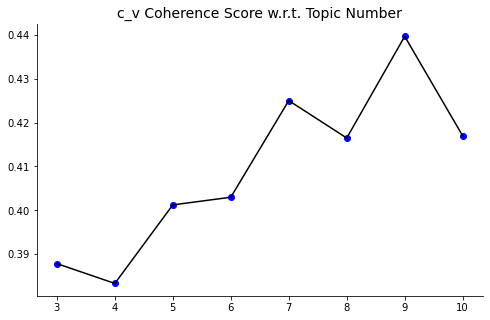

In [19]:
##https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
id2token_risk_article = corpora.Dictionary(list(risk_article['Phrase_Lemma_Tokens']))
corpus_risk_article = [id2token_risk_article.doc2bow(tokens) 
                        for tokens in list(risk_article['Phrase_Lemma_Tokens'])]

begin_time = time.time()
coherence_scores = []
for nb_topics in tqdm(range(3,11)):
    lda_model = LdaMulticore(corpus=corpus_risk_article,
                            id2word=id2token_risk_article,
                            num_topics=nb_topics, 
                            random_state=98,
                            chunksize=100,
                            passes=10,
                            iterations=30,
                            decay=0.5,
                            per_word_topics=True,)
    cm = CoherenceModel(model=lda_model, 
                        texts=list(risk_article['Phrase_Lemma_Tokens']),
                        dictionary=id2token_risk_article,
                        coherence='c_v',
                        topn=20)
    coherence_score = cm.get_coherence()
    coherence_scores.append(coherence_score)

print(f'Topic number selection took {time.time()-begin_time} seconds')

fig,ax = plt.subplots(figsize=(8,5))
ax.plot(range(3,11),coherence_scores,color='black')
ax.scatter(range(3,11),coherence_scores,marker='o',color='blue')
ax.set_xticks(range(3,11,1))
ax.set_title('c_v Coherence Score w.r.t. Topic Number',fontsize=14)
#ax.set_xlabel('Number of Topics',fontsize=14)
for pos in ['top','right']:
    ax.spines[pos].set_color(None)

In [20]:
%%time
lda_model = LdaMulticore(corpus=corpus_risk_article,
                        id2word=id2token_risk_article,
                        num_topics=9, 
                        random_state=98,
                        chunksize=100,
                        passes=10,
                        iterations=30,
                        decay=0.5,
                        per_word_topics=True,)

print('Perplexity: ', lda_model.log_perplexity(corpus_risk_article))

Perplexity:  -8.434666484611864
CPU times: total: 20min 4s
Wall time: 18min 9s


CPU times: total: 156 ms
Wall time: 166 ms


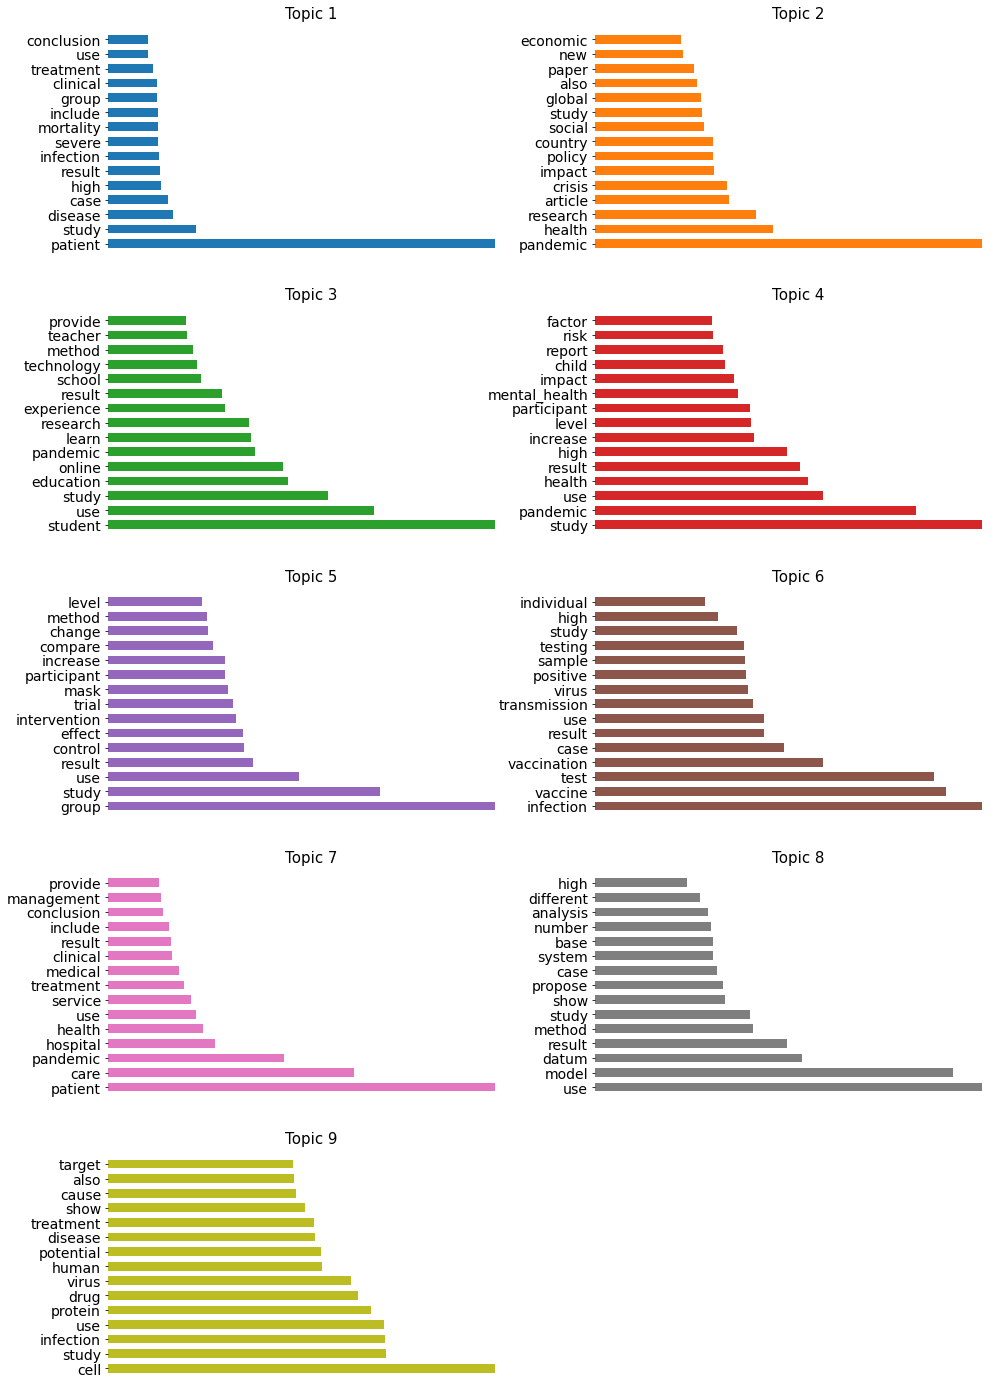

In [21]:
%%time
word_topic_scores = lda_model.show_topics(num_words=15,formatted=False)

fig = plt.figure(figsize=(16,25))
for i,topic in enumerate(word_topic_scores):
    word_score_pairs = topic[1]
    #word_score_dict = dict(topic[1])
    words = [word_score_pair[0] for word_score_pair in word_score_pairs]
    probs = [word_score_pair[1] for word_score_pair in word_score_pairs]
    #fig,ax = plt.subplots(figsize=(7,5))
    ax = fig.add_subplot(5,2,i+1)
    ax.barh(y=words,width=probs,height=0.6,color=sns.color_palette()[i])
    ax.set_yticklabels(labels=words, fontsize=14)
    ax.set_xticks([])
    ax.set_title(f'Topic {i+1}',fontsize=15)
    for pos in ['left','right','bottom','top']:
        ax.spines[pos].set_color(None)

总结的主题词：

1: Severity of Disease

2: Public and Social Service

3:Student health

4:Mental Health and Behavior

5:Experiments Methods

6:Transmission and prevention of Virus 

7: Treatment

8:Statistical analysis

9:Cell Level Reasearch

In [22]:
%%time
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, corpus_risk_article, id2token_risk_article)

CPU times: total: 1min 10s
Wall time: 1min 18s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.203987  0.017865       1        1  18.251875
0      0.175684  0.031262       2        1  15.629036
7     -0.053204  0.042029       3        1  13.583627
3      0.000550 -0.093834       4        1  11.916173
8      0.005794  0.182524       5        1  11.086136
6     -0.019122 -0.028194       6        1   9.999418
2     -0.174741 -0.077676       7        1   9.134815
5      0.118111  0.108708       8        1   7.026698
4      0.150914 -0.182684       9        1   3.372222, topic_info=           Term           Freq          Total Category  logprob  loglift
93      patient  397035.000000  397035.000000  Default  30.0000  30.0000
22         care   78605.000000   78605.000000  Default  29.0000  29.0000
14      student   60393.000000   60393.000000  Default  28.0000  28.0000
375       group   91458.000000   91458.000000  Default  27.0000  27.0000
334   infection  123882.000000  123882.000000  Default  26.0000  26.0000
..          ...            ...            ...      ...      ...      ...
172      method    5806.282793  109816.906842   Topic9  -5.0670   0.4497
719    evaluate    4568.978636   43720.537470   Topic9  -5.3067   1.1311
387      reduce    4651.010600   48254.472432   Topic9  -5.2889   1.0502
925    decrease    4280.729670   35447.051849   Topic9  -5.3718   1.2757
410  difference    4029.830958   26957.149981   Topic9  -5.4322   1.4891

[795 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2611      1  0.130785  academic
2611      2  0.042390  academic
2611      4  0.022172  academic
2611      6  0.101288  academic
2611      7  0.703251  academic
...     ...       ...       ...
128       6  0.079308      year
128       7  0.087737      year
128       8  0.058580      year
128       9  0.023516      year
1239      7  0.999243      zoom

[2643 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 8, 4, 9, 7, 3, 6, 5])

In [23]:
%%time
document_topic_distribution = []
num_topic_document = []
topic_frequency = {}
for i in range(len(corpus_risk_article)):
    # title_in_topic=[]
    document_topic = lda_model.get_document_topics(corpus_risk_article[i])
    document_topic_distribution.append(document_topic)
    num_topic_document.append(len(document_topic))
    for topic_idx,prob in document_topic:
        if topic_idx not in topic_frequency:
            topic_frequency[topic_idx] = 1
        else:
            topic_frequency[topic_idx] += 1
            # title_in_topic[topic_idx]

topic_frequency = dict(sorted(topic_frequency.items()))

CPU times: total: 1min 23s
Wall time: 1min 23s


CPU times: total: 62.5 ms
Wall time: 71.7 ms


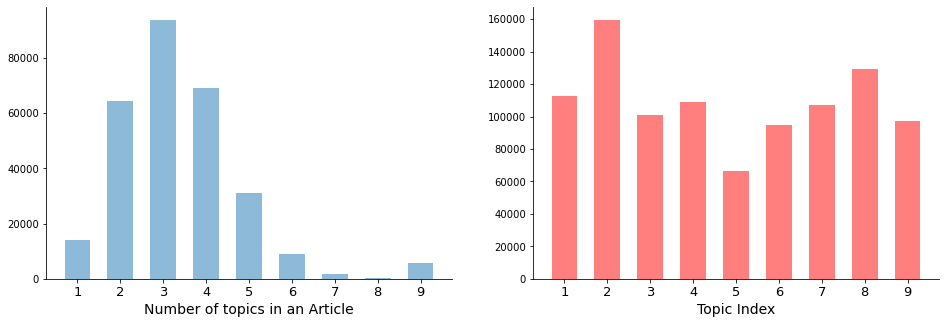

In [24]:
%%time
#num_topic_document_counter = collections.Counter(num_topic_document)
num_topic_document_counter = (pd.DataFrame(num_topic_document)).value_counts(sort=False)
counter_idx = [str(idx[0]) for idx in num_topic_document_counter.index]
counter_values = num_topic_document_counter.values
fig,axes = plt.subplots(figsize=(16,5),nrows=1,ncols=2)
axes[0].bar(counter_idx, counter_values,width=0.6,alpha=0.5)
axes[0].set_xlabel('Number of topics in an Article',fontsize=14)

df_topic_frequency = pd.DataFrame.from_dict(topic_frequency,orient='index')
topic_idxs = [str(idx+1) for idx in df_topic_frequency.index]
axes[1].bar(topic_idxs, df_topic_frequency.iloc[:,0], width=0.6,color='red',alpha=0.5)
axes[1].set_xlabel('Topic Index',fontsize=14)

for ax in axes:
    for pos in ['top','right']:
        ax.spines[pos].set_color(None)
    ax.set_xticklabels(['1','2','3','4','5','6','7','8','9'],fontsize=13)

1. The left figure shows that there are very few articles cover all the six topics or only one topic. 
2. The right figure shows that occurence frequencies of topics are very close .

In [25]:
## Generate document topic matrix
document_topic_matrix = np.zeros((len(corpus_risk_article),9))
for idx,document_topic in enumerate(document_topic_distribution):
    for topic_idx,prob in document_topic:
        document_topic_matrix[idx][topic_idx] = prob
pd.DataFrame(document_topic_matrix).head()

,0,1,2,3,4,5,6,7,8
0,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111
1,0.000000,0.000000,0.893343,0.000000,0.000000,0.000000,0.000000,0.000000,0.071267
2,0.000000,0.000000,0.071056,0.000000,0.000000,0.000000,0.394135,0.519273,0.000000
3,0.260068,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080199,0.650957
4,0.000000,0.000000,0.581684,0.000000,0.000000,0.000000,0.384457,0.000000,0.000000


In [ ]:
%%time
tSNE = TSNE(n_components=2,init='pca',random_state=98)
embedding_matrix = tSNE.fit_transform(document_topic_matrix)
df_embedding = pd.DataFrame(embedding_matrix, columns=['X_TSNE','Y_TSNE'])
cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 
                  3: 'red', 4: 'skyblue', 5:'salmon',
                  6:'brown',7:'purple',8:'orange'}
df_embedding['dominant_topic_idx'] = np.argmax(document_topic_matrix,axis=1)
df_embedding['color'] = df_embedding['dominant_topic_idx'].map(cluster_colors)
cluster_labels = {0: 'Severity of Disease', 1: 'Public and Social Service',2:'Student health',
                  3:'Mental Health and Behavior', 4:'Experiments Methods',5:'Transmission and prevention of Virus',
                  6: 'Treatment',7:'statistical analysis' ,8:'Cell Level Reasearch'}
df_embedding['label'] = df_embedding['dominant_topic_idx'].map(cluster_labels)
df_embedding['article_title'] = list(risk_article['title'])
df_embedding['abstract'] = list(risk_article['abstract'])


# print(df_embedding[df]['article_title'])
output_notebook()

source = ColumnDataSource(
    dict(x = df_embedding['X_TSNE'],
         y = df_embedding['Y_TSNE'],
         color=df_embedding['color'],
         label=df_embedding['label'],
         topic_key= df_embedding['dominant_topic_idx'],
         title= df_embedding['article_title'],
         #content = 
        ))

lda_plot = figure(title='T-SNE Clustering of LDA Topics', 
              plot_width=800, plot_height=600,
              tools='pan,wheel_zoom,box_zoom,reset,hover', 
              x_axis_type=None, y_axis_type=None)
lda_plot.scatter(x='x', y='y', source=source, 
                 legend='label', color='color',alpha=0.7, size=10)
hover = lda_plot.select(dict(type=HoverTool))
hover.tooltips = {'content':'Title: @title'}
lda_plot.legend.location = 'bottom_right'
show(lda_plot)

上面一个代码块的输出结果如下：（由于github上传文件大小受限，这里仅能展示聚类截图，正常运行即可）

<div align=center>
<img src="pic3\1.png" style="zoom:80%" />
</div>

In [27]:
%%time
for i in range(0,9):
    print("titles in topic{} are:".format(i))
    print(df_embedding[df_embedding['dominant_topic_idx']==i]['article_title'])

titles in topic0 are:
0         Coagulation profile in severe COVID-19 patient...
8         Comparison of effectiveness and survival after...
12        Global prevalence and pathogenesis of headache...
21        Comparison of Rituximab Originator With CT-P10...
22        Pegfilgrastim Maintains Relative Dose Intensit...
                                ...                        
289403    Efficacy and activity of PD-1 blockade in pati...
289414    Attitudes Towards Vaccination Against Coronavi...
289416    Asthma, from mild to severe, is an independent...
289417     Coronavirus-Associated Coagulopathy After Trauma
289419    Computed tomography-based volume calculations ...
Name: article_title, Length: 47386, dtype: object
titles in topic1 are:
6         Precompetitive Consensus Building to Facilitat...
17         Mental health outcomes of the CoViD-19 pandemic.
23        A multidimensional quality model: an opportuni...
28        [Ethics and Covid-19 in nursing homes, a retur...
32    

In [45]:
# 选择第二个topic下的所有abstract作为搜索范围，模拟用户选择
from random import sample
topic_selected=5
recommendation=df_embedding[df_embedding['dominant_topic_idx']==topic_selected]['abstract']
recommendations=sample(list(recommendation),100)

In [46]:
from transformers import  AutoTokenizer,AutoModelForQuestionAnswering
import torch
tokenizer = AutoTokenizer.from_pretrained("ktrapeznikov/biobert_v1.1_pubmed_squad_v2")

model = AutoModelForQuestionAnswering.from_pretrained("ktrapeznikov/biobert_v1.1_pubmed_squad_v2")

In [47]:
def getanswers(question):
    '''
    获得答案和相关度
    '''
    questions= []
    contexts= []
    for bigcontext in recommendations:
        bigcontext = bigcontext.split(" ")
        for i in range(int(len(bigcontext)/60)):
          contexts.append(" ".join(bigcontext[i*60:60*(i+1)]))
          questions.append(question) # 这里问题不需要做去停词、标点等处理比较好
    # num=0
    answers = []
    for question, context in zip(questions,contexts):
      try:
        result = ask(question,context)
        if len(result[0].split(" ")) < 10 or '[SEP]' in result[0].split(" "): # 回答短于10个词的不要,有本身问句在回答中的不要
          continue
        # num+=1
        answers.append([result[0],result[-2].item()])
        # if num==10:
        #   break
      except:
        continue

    return answers
def ask(question,context):
    input_ids = tokenizer.encode(question, context)
    sep_index = input_ids.index(tokenizer.sep_token_id)

    num_seg_a = sep_index + 1

    num_seg_b = len(input_ids) - num_seg_a
    # 其中0代表问题，1代表文本
    segment_ids = [0]*num_seg_a + [1]*num_seg_b
    assert len(segment_ids) == len(input_ids)
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    # tokens, for example: ['[CLS]', 'old', 'person', 'risk', '[SEP]', 'age','[SEP]']

    outputs = model(input_ids= torch.tensor([input_ids]),token_type_ids=torch.tensor([segment_ids]))

    answer_end = 0
    answer_start = torch.argmax(outputs.start_logits)
    answer_ends = torch.argsort(outputs.end_logits).numpy()[::-1]
    for i in answer_ends[0]:
        if answer_start<= i:
            answer_end= i

    answer = ' '.join(tokens[answer_start:answer_end+1])

    answer = answer.replace(" ##","").replace("[CLS] ","")

    pack = [answer,answer_start,answer_end,torch.max(outputs.start_logits),outputs.end_logits[0][answer_end],(torch.max(outputs.start_logits)+outputs.end_logits[0][answer_end]),context]
    return pack

In [48]:
Q='What do we know about COVID-19 risk factors?'
answers = getanswers(Q)
answers = pd.DataFrame(answers,columns = ['回答','置信度'])
answers.sort_values(by="置信度" , inplace=True, ascending=False)
answers.head(5)

,回答,置信度
27,it has been shown that immunity may not be pro...,10.798948
19,the impact of the removal of mask restrictions...,9.756174
22,factors associated with prolonged and increase...,8.328453
0,no effect on covid - 19 case fatality rate ( c...,7.889008
25,it is not known whether non - abo antibodies c...,7.781240


In [49]:
print("问题为：",Q)
num = 0 
for index, row in answers.iterrows():
    num+=1
    print("第{}条回答为：{}".format(num,row['回答']))
    
    if num==20:
        break

问题为： What do we know about COVID-19 risk factors?
第1条回答为：it has been shown that immunity may not be protective , and seroconversion delayed or absent
第2条回答为：the impact of the removal of mask restrictions , however , on covid - 19 outcomes for elementary students , educators / staff , and their households is not well known
第3条回答为：factors associated with prolonged and increased risk of transmission remain unclear
第4条回答为：no effect on covid - 19 case fatality rate ( cfr ) or number of deaths per population
第5条回答为：it is not known whether non - abo antibodies confer any protective effect against sars - cov - 2 infection or covid - 19 severe illness alone or in conjunction with o blood group
第6条回答为：countries which use mandatory bcg vaccination approach had lower covid - 19 infection and death rate
第7条回答为：this is the first study that evaluates the interdependencies of cellular and humoral immune responses following heterologous vaccination with astra / bnt in a large group of individuals
第8条回答